# YIN for Realtime Pitch-tracking

In this notebook we want to investigate the pYIN algorithm which is based on the YIN pitch tracking algorithm and develop a way to minimize the latency for realtime use.
The YIN algorithm is a pitch-tracking algorithm often used for speech and singing voice $f_0$ analysis.
The probabilistic YIN ist the modified YIN algorithm extended with a hidden Markov model (HMM).

First we investigate the YIN algorithm and its realtime capability and then we develop the pYIN version from it.


## YIN

The YIN pitch-tracking algorithm consists of 6 steps based on the autocorrelation method of $f_0$ analysis.
Each step reduces the error rate of the algorithm and provides the basis for the next step.
The steps are:

1. $r_t(\tau)$ autocorrelation function

2. $d_t(\tau)$ difference function

3. $d_t'(\tau)$ cummulative mean normalized difference function

4. get the minima under the absolute threshold

5. parabolic interpolation around the minima

6. best estimate


### 1. Autocorrelation function (ACF)

There are two versions of the autocorrelation function used in signal processing.
We use the following:

$$r_t(\tau) = \sum_{j = t+1}^{t+W} x_j \, x_{j+\tau}$$

$x_t$ ... discrete signal

$\tau$ ... time lag

$t$ ... time index

$W$ ... integration window size

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

The period is 88 samples.


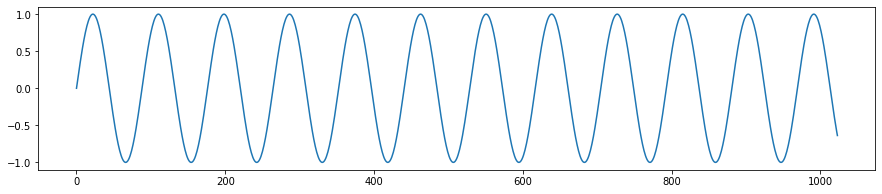

In [2]:
# let's start with a block of a sine signal
fs = 44100 # sample rate
W = 1024   # number of samples in the block

f = 500
t = np.linspace(0, W/fs, W)
x = np.sin(2*np.pi*f*t)

print("The period is", fs//f, "samples.")

plt.rcParams['figure.figsize'] = [15, 3]
plt.plot(x)
plt.show()

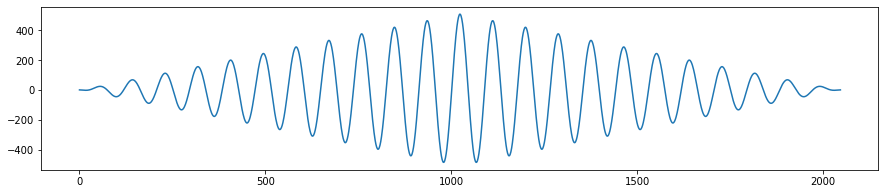

In [3]:
# compute the autocorrelation
r = np.correlate(x, x, "full")

plt.plot(r)
plt.show()

We see, that this is the second more commonly used correlation implementation, which is not used in YIN.

### 2. Difference function

$$d_t(\tau) = \sum_{j = 1}^{W} (x_j - x_{j+\tau})^2 = r_t(0) + r_{t+\tau}(0) - 2r_t(\tau)$$

The difference function can be obtained from the correlation but since this is the wrong implementation, we can compute it directly from the formula above.
We have a *YIN analysis block size* $a_{len}$ and the maximum period $\tau_{max}$ for a minimum frequency $f_{0,min}$.
The actual processed block is of length $a_{len} + \tau_{max}$.
For a longer signal, we would do block processing with a *hop-size*.
This implementation is inspired by DAFX by Udo Zölzer.

In [4]:
def differenceFunction(x, a_len, tau_max):
    d = np.zeros(tau_max)
    for tau in range(tau_max):
        for j in range(a_len):
            d[tau] += (x[j] - x[j+tau])**2
    return d

tau_max: 441


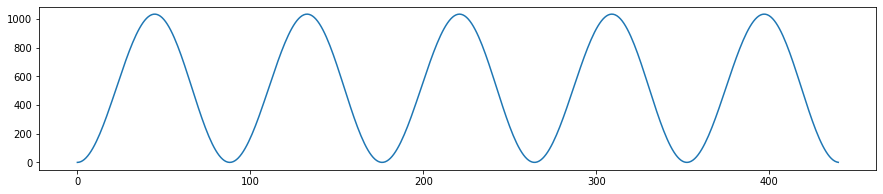

In [5]:
a_len = 512 # YIN analysis length

f0_min = 100 # minimum frequency
tau_max = fs//f0_min
print("tau_max:", tau_max)

# get one block from the signal
x_block = x[:a_len+tau_max]

d = differenceFunction(x_block, a_len, tau_max)

plt.plot(d)
plt.show()

The minima are at zero and at $n \cdot T$ of $x_j$ but the function is amplitude dependent, so we need normalization.

### 3. Cumulative mean normalized difference function

$$
d_t'(\tau) = \left\{ \begin{array}{ll} 1 \quad if \quad \tau = 0 \\ \frac{d_t(\tau)}{\frac{1}{\tau} \sum_{j = 1}^{\tau} d_t(j) } \end{array} \right.
$$

In [6]:
def CMNDF(d, tau_max):
    d_norm = np.zeros(tau_max)
    d_norm[0] = 1
    d_sum = 0
    
    for tau in range(1, tau_max):
        d_sum += d[tau]
        d_norm[tau] = d[tau] * (tau/d_sum) # rearranged formula
    return d_norm

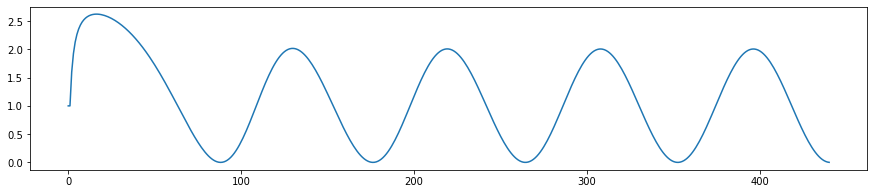

In [7]:
d_norm = CMNDF(d, tau_max)

plt.plot(d_norm)
plt.show()

This function is independent of amplitude and the first minimum is at the period $T$.


### 4. Get the minima under the absolute threshold

Now we calculate the  first minimum below a threshold to get the period estimate and from it the fundamental frequency estimate of the signal.

In [8]:
def get_first_min(d_norm, threshold, tau_max):
    tau = 0

    while tau < tau_max:
        if d_norm[tau] < threshold:
            # search turning point
            while d_norm[tau + 1] < d_norm[tau]:
                tau += 1
            return tau
        else:
            tau += 1
    # if no pitch detected
    tau = np.nan
    return tau

In [9]:
threshold = 0.1
tau = get_first_min(d_norm, threshold, tau_max)

f_0 = fs / tau
print("tau:", tau, "f_0:", f_0)

tau: 88 f_0: 501.1363636363636


### 5. Parabolic interpolation

To refine the esimate, the "local minimum and its immediate neighbours are fit by a parabola."

The following code is taken from the pYIN implementation by Matthias Mauch.

In [10]:
def parabolicInterpolation(buffer, tau):
    if tau == d_norm.size:
        return tau
    
    better_tau = 0
    if tau > 0 and tau < buffer.size - 1:
        s0 = buffer[tau - 1]
        s1 = buffer[tau]
        s2 = buffer[tau + 1]
        
        adjustment = (s2 - s0) / (2 * (2*s1 - s2 - s0))
        if abs(adjustment) > 1:
            adjustment = 0
        
        better_tau = tau + adjustment
    else:
        better_tau = tau
    return better_tau

In [11]:
if tau != 0:
    better_tau = parabolicInterpolation(d_norm, tau)
    better_f_0 = fs / better_tau
else:
    better_tau = 0
    better_f_0 = 0

print("better_tau:", tau, ", better_f_0:", f_0)

better_tau: 88 , better_f_0: 501.1363636363636


### 6. Best local estimate

The paper describes a method similar to "median smoothing or dynamic programming techniques" to pick the best local estimate.
In practice, this is not used in the implementations (librosa, pYIN by Mauch)


## The YIN algorithm

So that is the final YIN algorithm:

In [12]:
def yin(x, fs, fmin=100, hop_size=1024, threshold=0.1):
    """
    The YIN pitch-tracking algorithm
    in a strictly time domain implementation
    for real-time use.
    """
    
    tau_max = round(fs/f0_min)
    yin_size = 2*tau_max
    
    f0 = []
    for i in range(x.size // hop_size - 1):
        x_block = x[i*hop_size : (i+1) * hop_size]
        d = differenceFunction(x_block, yin_size, tau_max)
        d_norm = CMNDF(d, tau_max)
        tau = get_first_min(d_norm, threshold, tau_max)
        
        if tau != 0:
            better_tau = parabolicInterpolation(d_norm, tau)
            better_f0 = fs / better_tau
        else:
            better_tau = 0
            better_f0 = 0
        
        f0.append(better_f0)
    
    return np.asarray(f0)

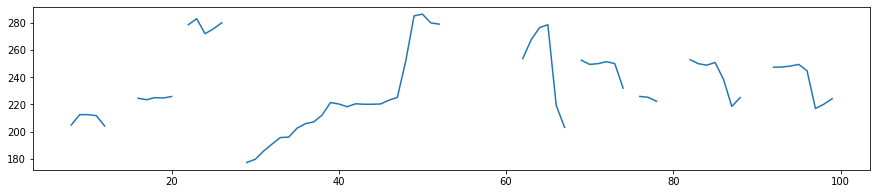

In [13]:
x, fs = librosa.load("../../samples/Toms_diner.wav")

f0 = yin(x, fs)

plt.plot(f0)
plt.show()

### Real-time use

The minimum check of the CMNDF can be done as soon as a block of $T_{max}$ samples is available.
This would lead to a variable and sometimes smaller latency than $t_{lat} = 2T_{max}$ in the range of $t_{lat} = T_{max} + T$.
